In [9]:
load_train = [1053, 1136, 1268, 920, 1334, 1192, 998, 975, 1112]
MVA_train = [951566, 1116947, 1240137, 1107984, 1066611, 1086039, 1007095, 979700, 1027445]
load_test = [707062, 867009, 854955, 773049, 1160968, 1146118, 1133241]

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [110]:
trainX = pd.Series(load_train)
trainY = pd.Series(MVA_train)
testX = pd.Series(load_test)/1000
trainset = pd.DataFrame({'load':trainX, 'MVA': trainY})
trainset

,MVA,load
0,951566,1053
1,1116947,1136
2,1240137,1268
3,1107984,920
4,1066611,1334
5,1086039,1192
6,1007095,998
7,979700,975
8,1027445,1112


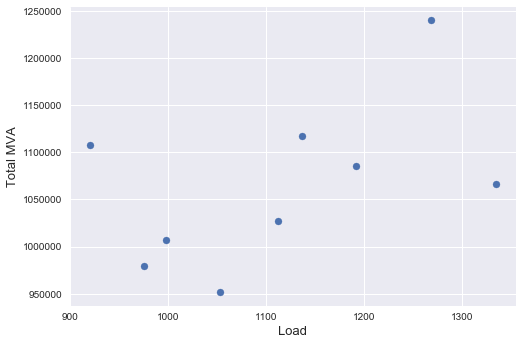

In [22]:
fig, ax = plt.subplots()
ax.scatter(x = trainX, y = trainY)
plt.xlabel('Load', fontsize=13)
plt.ylabel('Total MVA', fontsize=13)
plt.show()

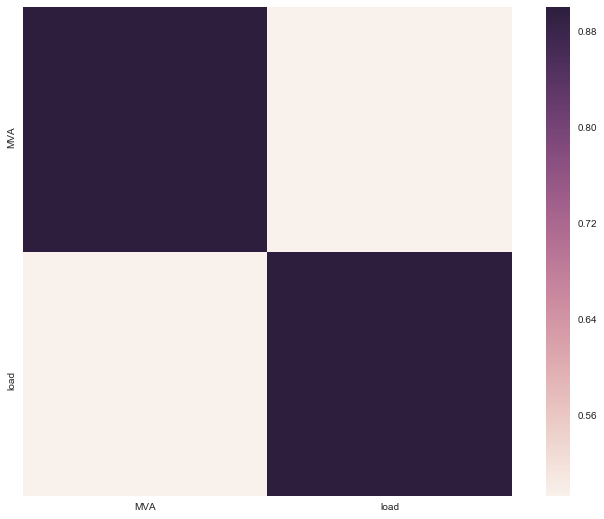

,MVA,load
MVA,1.000000,0.492224
load,0.492224,1.000000


In [23]:
#Correlation map to see how features are correlated with SalePrice
corrmat = trainset.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)
plt.show()
corrmat

In [25]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [45]:
trainY / 1000

0     951.566
1    1116.947
2    1240.137
3    1107.984
4    1066.611
5    1086.039
6    1007.095
7     979.700
8    1027.445
dtype: float64

In [94]:
n_folds = 3

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(trainX.values.reshape(-1, 1))
    rmse= np.sqrt(-cross_val_score(model, trainX.values.reshape(-1, 1), trainY.values / 1000, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [30]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [47]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 121.2817 (43.7637)



In [38]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [48]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 121.2787 (43.7582)



In [55]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [56]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 122.1442 (45.0870)



In [57]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 88.8746 (36.4717)



In [166]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=5, 
                             min_child_weight=1.7817, n_estimators=1000,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [167]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 90.9288 (24.3944)



In [51]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [52]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 86.8821 (38.6221)



In [58]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [59]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 110.8095 (27.2272)



In [95]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=3):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([np.column_stack([model.predict(X) for model in base_models]).mean(axis=1) for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [96]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 95.8332 (40.4461)


In [97]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [118]:
stacked_averaged_models.fit(trainX.values.reshape(-1, 1), trainY/1000)
stacked_train_pred = stacked_averaged_models.predict(trainX.values.reshape(-1, 1))
stacked_pred =stacked_averaged_models.predict(testX.values.reshape(-1, 1))
print(rmsle(trainY/1000, stacked_train_pred))

71.3337468914


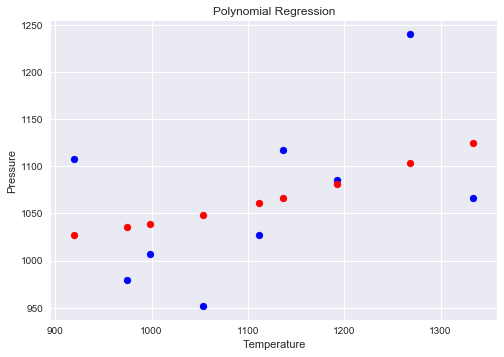

In [158]:
# Visualising the Polynomial Regression results 
plt.scatter(trainX, trainY/1000, color = 'blue') 

plt.scatter(trainX, stacked_train_pred , color = 'red') 
plt.title('Polynomial Regression') 
plt.xlabel('Temperature') 
plt.ylabel('Pressure') 

plt.show() 

In [119]:
model_xgb.fit(trainX.values.reshape(-1, 1), trainY/1000)
xgb_train_pred = model_xgb.predict(trainX.values.reshape(-1, 1))
xgb_pred = model_xgb.predict(testX.values.reshape(-1, 1))
print(rmsle(trainY/1000, xgb_train_pred))

50.9633233704


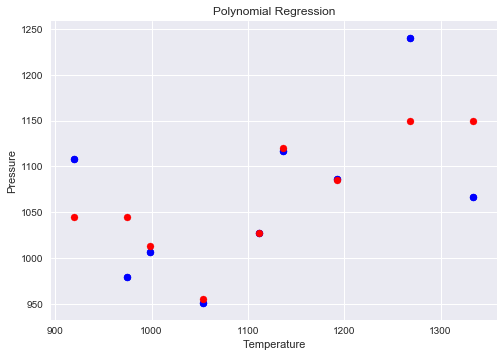

In [157]:
# Visualising the Polynomial Regression results 
plt.scatter(trainX, trainY/1000, color = 'blue') 

plt.scatter(trainX, xgb_train_pred , color = 'red') 
plt.title('Polynomial Regression') 
plt.xlabel('Temperature') 
plt.ylabel('Pressure') 

plt.show() 

In [120]:
model_lgb.fit(trainX.values.reshape(-1, 1), trainY/1000)
lgb_train_pred = model_lgb.predict(trainX.values.reshape(-1, 1))
lgb_pred = model_lgb.predict(testX.values.reshape(-1, 1))
print(rmsle(trainY/1000, lgb_train_pred))

82.0371230453


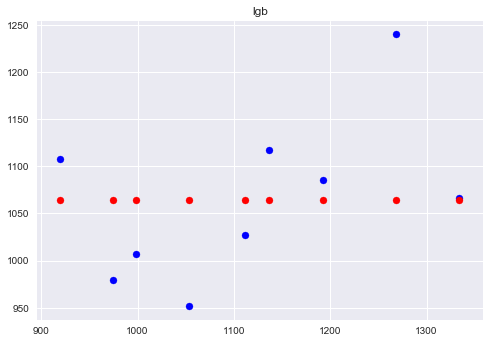

In [159]:
# Visualising the Polynomial Regression results 
plt.scatter(trainX, trainY/1000, color = 'blue') 

plt.scatter(trainX, lgb_train_pred , color = 'red') 
plt.title('lgb') 

plt.show() 

In [121]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(trainY/1000,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
67.6979449755


In [122]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [152]:
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LinearRegression 
poly = PolynomialFeatures(degree = 6) 
X_poly = poly.fit_transform(trainX.values.reshape(-1, 1)) 
poly.fit(X_poly, trainY/1000) 
lin2 = LinearRegression() 
lin2.fit(X_poly, trainY/1000) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

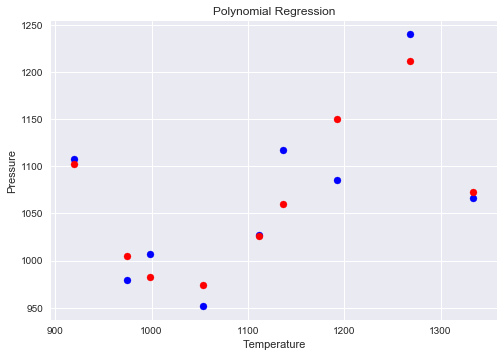

In [153]:
# Visualising the Polynomial Regression results 
plt.scatter(trainX, trainY/1000, color = 'blue') 

plt.scatter(trainX, lin2.predict(poly.fit_transform(trainX.values.reshape(-1, 1))), color = 'red') 
plt.title('Polynomial Regression') 
plt.xlabel('Temperature') 
plt.ylabel('Pressure') 

plt.show() 

In [155]:
for k in range(3, 10):
    poly = PolynomialFeatures(degree = k) 
    X_poly = poly.fit_transform(trainX.values.reshape(-1, 1)) 
    poly.fit(X_poly, trainY/1000) 
    lin2 = LinearRegression() 
    lin2.fit(X_poly, trainY/1000) 
    polyLR = lin2.predict(poly.fit_transform(trainX.values.reshape(-1, 1)))
    print('RMSLE score on train data:')
    print('k=', k, rmsle(trainY/1000,polyLR ))

RMSLE score on train data:
k= 3 36.1570778416
RMSLE score on train data:
k= 4 33.4224192932
RMSLE score on train data:
k= 5 33.2062939974
RMSLE score on train data:
k= 6 33.0759410546
RMSLE score on train data:
k= 7 33.0383894647
RMSLE score on train data:
k= 8 33.103190412
RMSLE score on train data:
k= 9 33.2810864558
